# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [15]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install pyogrio

Note: you may need to restart the kernel to use updated packages.


In [2]:
# all import statements needed for the project, for example:

import math

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
import re

In [20]:
# any general notebook setup, like log formatting

In [3]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///final_project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_**TODO:** Write some prose that tells the reader what you're about to do here._

In [22]:
def calculate_distance(from_coord, to_coord):
    # unpack from_coord & to_coord
    lon1, lat1 = from_coord
    lon2, lat2 = to_coord
    # set radius of earth
    earth_r = 6371
    # convert distance between lats & lons to radians
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    # solve for distance using haversine function 
    a = (math.sin(dlat / 2) ** 2 +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) **2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dis = earth_r * c
    return dis

In [23]:
def add_distance_column(dataframe):
    # add new column distance
    dataframe['distance'] = np.nan
    # iterate over all rows and add calculated distance
    for index, row in dataframe.iterrows():
        dataframe.loc[index,'distance'] = calculate_distance((row["pickup_longitude"],row["pickup_latitude"]),(row["dropoff_longitude"],row["dropoff_latitude"]))                                       
    return dataframe

### Processing Taxi Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [24]:
def get_taxi_html():
    response = requests.get(TAXI_URL)
    html = response.content
    return html

def find_taxi_csv_urls():
    html = get_taxi_html()
    soup = bs4.BeautifulSoup(html, 'html.parser')    
    urls = [link.get('href') for link in soup.find_all(title="Yellow Taxi Trip Records")]
    expected=[]
    pattern1 = re.compile(r".*2009-\d\d.parquet")
    pattern2 = re.compile(r".*201[0-4]-\d\d.parquet")
    pattern3 = re.compile(r".*2015-0[1-6].parquet")
    for link in urls:
        match= pattern1.search(link)
        if match:
            expected.append(match.string)
    for link in urls:
        match= pattern2.search(link)
        if match:
            expected.append(match.string)
    for link in urls:
        match= pattern3.search(link)
        if match:
            expected.append(match.string)
    return expected

In [25]:
def get_and_clean_month_taxi_data(url):
    df = pd.read_parquet(url, engine='pyarrow')
    #normalizing column names
    if "tpep_pickup_datetime" in df.columns:
        df.rename(columns={"tpep_pickup_datetime": "pickup_datetime", 
                           "tpep_dropoff_datetime":"dropoff_datetime"}, inplace=True)
    
    if "Start_Lon" in df.columns:
        df.rename(columns={"Start_Lon": "pickup_longitude",
                          "End_Lon": "dropoff_longitude",
                          "Start_Lat": "pickup_latitude",
                          "End_Lat": "dropoff_latitude",
                           "Trip_Pickup_DateTime": "pickup_datetime", 
                            "Tip_Amt": "tip_amount"}, inplace=True)
    
    #extract longitude & latitude from location ids
    if "PULocationID" in df.columns:
        GeoSeries= gpd.read_file(filename="taxi_zones.zip",engine="pyogrio")
        g=GeoSeries.to_crs(epsg=4326)
        g["longtitude"]=g.geometry.centroid.x
        g["latitude"]=g.geometry.centroid.y
        df["pickup_latitude"]=df["PULocationID"].map(g["latitude"])
        df["pickup_longitude"]=df["PULocationID"].map(g["longtitude"])
        df["dropoff_latitude"]=df["DOLocationID"].map(g["latitude"])
        df["dropoff_longitude"]=df["DOLocationID"].map(g["longtitude"])
    
    # only select columns we need to keep
    cols_to_keep = ["pickup_datetime","pickup_longitude","dropoff_longitude","pickup_latitude","dropoff_latitude","tip_amount"]
    df = df[cols_to_keep]
    
    # convert pickup_datetime column to datetime
    df["pickup_datetime"] = pd.to_datetime(df.pickup_datetime)
    
    #removing data outside new york coords
    df = df[(df.pickup_longitude>=NEW_YORK_BOX_COORDS[0][1])&(df.pickup_longitude<=NEW_YORK_BOX_COORDS[1][1])
                   & (df.pickup_latitude>=NEW_YORK_BOX_COORDS[0][0]) & (df.pickup_latitude<=NEW_YORK_BOX_COORDS[1][0])
                   & (df.dropoff_longitude>=NEW_YORK_BOX_COORDS[0][1])&(df.dropoff_longitude<=NEW_YORK_BOX_COORDS[1][1])
                   & (df.dropoff_latitude>=NEW_YORK_BOX_COORDS[0][0]) & (df.pickup_latitude<=NEW_YORK_BOX_COORDS[1][0])
                   & (df.dropoff_latitude!=df.pickup_latitude) & (df.pickup_longitude!=df.dropoff_longitude)]
    
    # sample 2500 rows per file to match uber dataset
    df = df.sample(2500)
    return df

In [26]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month_taxi_data(csv_url)
        add_distance_column(dataframe)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        
        all_taxi_dataframes.append(dataframe)
        
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

### Processing Uber Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [27]:
def load_and_clean_uber_data(csv_file):
    # get dataframe from uber csv
    df = pd.read_csv(csv_file)
    # rename column
    df.rename(columns={'Unnamed: 0':'id'}, inplace=True)
    # convert pickup_datetime column to datetime
    df["pickup_datetime"] = pd.to_datetime(df.pickup_datetime)
    # drop unnecessary columns
    df.drop(["id","key"], axis=1, inplace=True)
    # only select trips within new york coords & positive fare amount & positive passenger count
    cleaned_df = df[(df.pickup_longitude>=NEW_YORK_BOX_COORDS[0][1])&(df.pickup_longitude<=NEW_YORK_BOX_COORDS[1][1])
                   & (df.pickup_latitude>=NEW_YORK_BOX_COORDS[0][0]) & (df.pickup_latitude<=NEW_YORK_BOX_COORDS[1][0])
                   & (df.dropoff_longitude>=NEW_YORK_BOX_COORDS[0][1])&(df.dropoff_longitude<=NEW_YORK_BOX_COORDS[1][1])
                   & (df.dropoff_latitude>=NEW_YORK_BOX_COORDS[0][0]) & (df.pickup_latitude<=NEW_YORK_BOX_COORDS[1][0])
                   & (df.passenger_count>0) & (df.fare_amount>0)]
    # drop unnecessary columns
    cleaned_df = cleaned_df.drop(["fare_amount","passenger_count"], axis=1).copy()
    return cleaned_df

In [28]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

### Processing Weather Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [29]:
def clean_month_weather_data_hourly(csv_file):
    df=pd.read_csv(csv_file,low_memory=False)
    if df["HourlyPrecipitation"] is"NaN":
        df["HourlyPrecipitation"]=df["DailyPrecipitation"]/24
    if df["HourlyWindSpeed"] is "NaN":
        df["HourlyWindSpeed"]=df["DailyAverageWindSpeed"]/24
    df["DATE"] = pd.to_datetime(df["DATE"])
    df["HourlyPrecipitation"] = df["HourlyPrecipitation"].replace(["T"],"0.00" )
    df_new=df[["DATE","HourlyPrecipitation","HourlyWindSpeed"]]
    df_new.dropna(inplace=True)
    return df_new
    #replace T by 0.0,T means trace amount is greater than 0 but very small 
    #drop all blank rows and replace some blank rows by daily amount/24
    #clean the date and choose three specific column for the following questions
    

In [30]:
def clean_month_weather_data_daily(csv_file):
    df2=pd.read_csv(csv_file,low_memory=False)
    if df2["DailyAverageWindSpeed"] is "NaN":
        df2["DailyAverageWindSpeed"]=df2["HourlyWindSpeed"]*24
    df2["DATE"] = pd.to_datetime(df2["DATE"])
    df_new2=df2[["DATE","DailyAverageWindSpeed"]]
    df_new2.dropna(inplace=True)
    return df_new2
    #raise NotImplemented()

In [31]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    weather_csv_files = ["2009_weather.csv" ,"2010_weather.csv","2011_weather.csv","2012_weather.csv","2013_weather.csv","2014_weather.csv","2015_weather.csv"]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [32]:
taxi_data = pd.read_csv("taxi_file_final.csv")

In [33]:
#taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [4]:
engine = db.create_engine(DATABASE_URL)

In [35]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    hourlyid INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATETIME,
    HourlyPrecipitation FLOAT,
    HourlyWindSpeed FLOAT
);

"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    dailyid INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATETIME,
    DailyAverageWindSpeed FLOAT
);

"""
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
   taxi_id INTEGER PRIMARY KEY AUTOINCREMENT,
   pickup_datetime DATETIME,
   pickup_longitude DOUBLE,
   pickup_latitude DOUBLE,
   dropoff_longitude DOUBLE,
   dropoff_latitude DOUBLE,
   tip_amount FLOAT,
   distance DOUBLE
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
   uber_id INTEGER PRIMARY KEY AUTOINCREMENT,
   pickup_datetime DATETIME,
   pickup_longitude DOUBLE,
   pickup_latitude DOUBLE,
   dropoff_longitude DOUBLE,
   dropoff_latitude DOUBLE,
   distance DOUBLE
);
"""

In [36]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [37]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [38]:
def write_dataframes_to_table(table_to_df_dict):
    for table, data in table_to_df_dict.items():
        df=data
        df.to_sql(table, con=engine, if_exists='append',index=False)

In [39]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [40]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [41]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

### Query N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

### Query 1
For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.

In [42]:
QUERY_1 = """SELECT strftime ('%H',pickup_datetime) AS Hr, count(*) AS Ct
FROM taxi_trips GROUP BY strftime ('%H',pickup_datetime)"""

In [43]:
engine.execute(QUERY_1).fetchall()

[('00', 7759),
 ('01', 5971),
 ('02', 4273),
 ('03', 3118),
 ('04', 2294),
 ('05', 1893),
 ('06', 4083),
 ('07', 6922),
 ('08', 8682),
 ('09', 9072),
 ('10', 8780),
 ('11', 9028),
 ('12', 9458),
 ('13', 9309),
 ('14', 9691),
 ('15', 9241),
 ('16', 7998),
 ('17', 9520),
 ('18', 11847),
 ('19', 12321),
 ('20', 11435),
 ('21', 11403),
 ('22', 10994),
 ('23', 9908)]

In [44]:
write_query_to_file(QUERY_1, "most_popular_hour_taxi.sql")

### Query 2
For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.

In [45]:
QUERY_2 = """SELECT strftime('%w',pickup_datetime) AS Day, count(*) AS Ct
FROM uber_trips GROUP BY strftime('%w',pickup_datetime)"""

In [46]:
engine.execute(QUERY_2).fetchall()

[('0', 25775),
 ('1', 24569),
 ('2', 27416),
 ('3', 28239),
 ('4', 29253),
 ('5', 30072),
 ('6', 29497)]

In [47]:
write_query_to_file(QUERY_2, "most_popular_day_uber.sql")

### Query 3
What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [48]:
QUERY_3 = """
WITH hired_trips AS (
SELECT pickup_datetime, distance FROM taxi_trips 
WHERE strftime("%Y-%m", pickup_datetime)="2013-07" UNION ALL 
SELECT pickup_datetime, distance FROM uber_trips
WHERE strftime("%Y-%m", pickup_datetime)='2013-07'
)
SELECT distance from (SELECT
    distance,
    printf('%.2f', PERCENT_RANK() OVER( 
        ORDER BY distance 
    )) Rank FROM hired_trips ORDER BY Rank DESC)
    WHERE Rank ='0.95' LIMIT 1
"""

In [49]:
engine.execute(QUERY_3).fetchall()

[(22.56718893563213,)]

In [50]:
write_query_to_file(QUERY_3, "95_percentile_distance.sql")

### Query 4
What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [51]:
QUERY_4 = """ SELECT strftime('%Y-%m-%d', pickup_datetime), count(*), AVG(distance) FROM(
SELECT pickup_datetime, distance FROM uber_trips WHERE strftime('%Y', pickup_datetime)='2009'
UNION ALL
SELECT pickup_datetime, distance FROM taxi_trips WHERE strftime('%Y', pickup_datetime)='2009') 
GROUP BY strftime('%Y-%m-%d', pickup_datetime) ORDER BY count(*) DESC
LIMIT 10
;
"""

In [52]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 228, 3.009219759085025),
 ('2009-05-08', 226, 3.3444767154601287),
 ('2009-10-23', 222, 2.623900049808902),
 ('2009-12-18', 221, 2.88887938685852),
 ('2009-11-05', 213, 3.559968742904005),
 ('2009-04-18', 212, 3.4120530469894748),
 ('2009-12-05', 211, 3.0284544809751477),
 ('2009-08-14', 210, 3.5734338419492544),
 ('2009-07-21', 208, 3.178228785312645),
 ('2009-12-16', 207, 3.2849741389773137)]

In [53]:
write_query_to_file(QUERY_4, "top_10_days_hired_rides_2009.sql")

### Query 5
Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?

In [54]:
QUERY_5 = """
WITH pickup_datetime AS (
SELECT strftime("%Y-%m-%d", DATE) 
FROM daily_weather 
GROUP BY strftime("%Y-%m-%d", DATE)
ORDER by DailyAverageWindSpeed DESC  
LIMIT 10
)
SELECT (SELECT COUNT(*) FROM taxi_trips where taxi_trips.pickup_datetime==pickup_datetime ) 
+ (SELECT COUNT(*) FROM uber_trips where uber_trips.pickup_datetime==pickup_datetime) AS total
"""

In [55]:
engine.execute(QUERY_5).fetchall()

[(389821,)]

In [56]:
write_query_to_file(QUERY_5, "top_10_windiest_days.sql")

### Query 6

In [57]:
QUERY_6 = """
WITH new_trips AS (
SELECT strftime ('%Y-%m-%d %H',pickup_datetime) AS Hr, count(*) AS Ct FROM(
SELECT pickup_datetime FROM uber_trips 
WHERE strftime('%Y-%m-%d',pickup_datetime) IN ('2012-10-22','2012-10-23','2012-10-24','2012-10-25','2012-10-26','2012-10-27','2012-10-28','2012-10-29','2012-10-30') 
UNION ALL
SELECT pickup_datetime FROM taxi_trips
WHERE strftime('%Y-%m-%d',pickup_datetime) IN ('2012-10-22','2012-10-23','2012-10-24','2012-10-25','2012-10-26','2012-10-27','2012-10-28','2012-10-29','2012-10-30') 
)
GROUP BY strftime ('%Y-%m-%d %H',pickup_datetime)
), new_weather AS(
SELECT strftime ('%Y-%m-%d %H',date) AS Hr, HourlyPrecipitation, HourlyWindSpeed FROM hourly_weather 
WHERE strftime('%Y-%m-%d', date) IN ('2012-10-22','2012-10-23','2012-10-24','2012-10-25','2012-10-26','2012-10-27','2012-10-28','2012-10-29','2012-10-30') 
GROUP BY strftime ('%Y-%m-%d %H',date)
)

SELECT  new_trips.Hr, new_trips.Ct, coalesce(new_weather.HourlyPrecipitation, 0), coalesce(new_weather.HourlyWindSpeed, 0) 
FROM new_trips LEFT JOIN new_weather ON new_weather.Hr =new_trips.Hr

"""


In [58]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00', 3, '0.00', 7.0),
 ('2012-10-22 01', 4, '0.00', 5.0),
 ('2012-10-22 02', 1, '0.00', 7.0),
 ('2012-10-22 03', 3, '0.00', 0.0),
 ('2012-10-22 05', 1, '0.00', 0.0),
 ('2012-10-22 06', 5, '0.00', 5.0),
 ('2012-10-22 07', 10, '0.00', 3.0),
 ('2012-10-22 08', 5, '0.00', 3.0),
 ('2012-10-22 09', 7, '0.00', 5.0),
 ('2012-10-22 10', 8, 0, 0),
 ('2012-10-22 11', 12, 0, 0),
 ('2012-10-22 12', 10, '0.00', 11.0),
 ('2012-10-22 13', 17, 0, 0),
 ('2012-10-22 14', 5, '0.00', 7.0),
 ('2012-10-22 15', 11, '0.00', 6.0),
 ('2012-10-22 16', 7, '0.00', 3.0),
 ('2012-10-22 17', 6, '0.00', 7.0),
 ('2012-10-22 18', 13, '0.00', 5.0),
 ('2012-10-22 19', 5, '0.00', 5.0),
 ('2012-10-22 20', 11, '0.00', 3.0),
 ('2012-10-22 21', 5, '0.00', 0.0),
 ('2012-10-22 22', 10, '0.00', 3.0),
 ('2012-10-23 00', 4, 0, 0),
 ('2012-10-23 01', 4, 0, 0),
 ('2012-10-23 02', 1, 0, 0),
 ('2012-10-23 04', 2, 0, 0),
 ('2012-10-23 05', 2, 0, 0),
 ('2012-10-23 06', 4, 0, 0),
 ('2012-10-23 07', 8, 0, 0),
 ('2012-10-23 08'

In [59]:
write_query_to_file(QUERY_6, "Hurricane_NYC.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

In [7]:
def get_data_for_visual_n(QUERY_N):
    df = pd.read_sql_query(QUERY_N, con=engine)
    return df

### Visualization 1
Create an appropriate visualization for the first query/question in part 3

In [61]:
def plot_most_popular_hour():
    # get the data of hired taxi trips group by 24-hour
    df=get_data_for_visual_n(QUERY_1)
    # set hour as x-axis & count as y-axis
    x=df["Hr"]
    y=df["Ct"]
    # label x & y axes
    plt.xlabel("Hour")
    plt.ylabel("Count")
    # set title
    plt.title("Most Popular Hour of Yellow Taxi")
    # make bar graph
    plt.bar(x,y)
    plt.show()

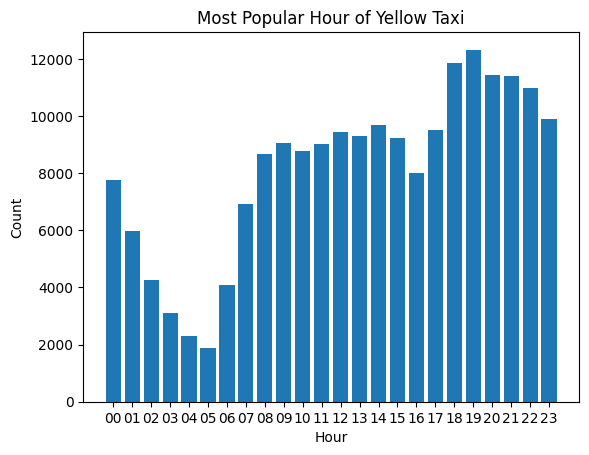

In [62]:
plot_most_popular_hour()

### Visualization 2
Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization

In [63]:
def avg_dis_per_month():
    # get avg distance per month from all trips
    query="""SELECT strftime ('%m',pickup_datetime) as Month, AVG(distance) as AvgDis FROM
    (SELECT pickup_datetime, distance FROM uber_trips UNION ALL
    SELECT pickup_datetime, distance FROM taxi_trips)
    GROUP BY strftime ('%m',pickup_datetime)"""
    df=get_data_for_visual_n(query)
    # set month as x-axis & avg distance as y-axis
    x=df["Month"]
    y=df["AvgDis"]
    # calculate the 90% confidence interval for avg distance
    ci = 1.645 * np.std(y)/np.sqrt(len(y))
    # label x & y axes
    plt.xlabel("Month")
    plt.ylabel("Average Distance")
    # set title
    plt.title("Average Distance Per Month")
    # plot avg distance on month
    plt.plot(x,y)
    # plot 90% confidence interval
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=0.5)
    plt.show()

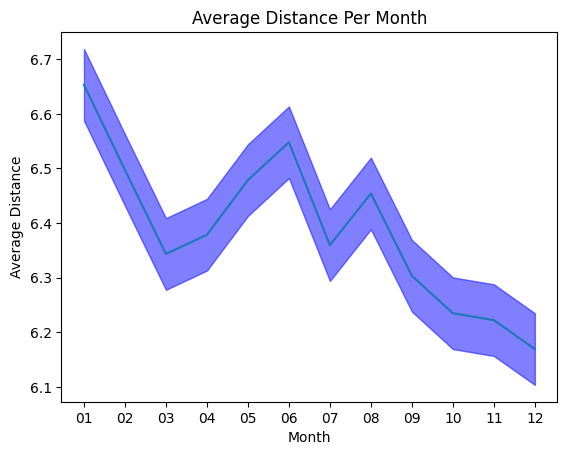

In [64]:
avg_dis_per_month()

### Visualization 3
Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

In [65]:
# get lat/long coordinate boxes around three airports
lga_coords=((-73.890314,40.766578),(-73.862762,40.774314))
jfk_coords=((-73.826635,40.621911),(-73.743036,40.673748))
ewr_coords=((-74.200639,40.671241),(-74.150170,40.715754))

In [66]:
def plot_dropoffs_for_lga_airport():
    # select trips with dropoffs at lga airport from all trips, count and group by day of week
    query="""SELECT strftime("%w", pickup_datetime) AS Day, count(*) AS Ct FROM 
    (SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM uber_trips 
    WHERE dropoff_longitude>=-73.890314 AND dropoff_longitude<=-73.862762 AND dropoff_latitude>=40.766578 AND dropoff_latitude<=40.774314
    UNION ALL
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM taxi_trips
    WHERE dropoff_longitude>=-73.890314 AND dropoff_longitude<=-73.862762 AND dropoff_latitude>=40.766578 AND dropoff_latitude<=40.774314
    )
    GROUP BY strftime("%w", pickup_datetime)"""
    df=get_data_for_visual_n(query)
    # choose day as x-axis & counts as y-axis
    x=df["Day"]
    y=df["Ct"]
    # label x & y axes
    plt.xlabel("Day")
    plt.ylabel("Count")
    # set title
    plt.title("Most Popular Day of LGA")
    # make bar graph
    plt.bar(x,y)
    plt.show()

In [72]:
def plot_dropoffs_for_jfk_airport():
    # select trips with dropoffs at jfk airport from all trips, count and group by day of week
    query="""SELECT strftime("%w", pickup_datetime) AS Day, count(*) AS Ct FROM 
    (SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM uber_trips 
    WHERE dropoff_longitude>=-73.826635 AND dropoff_longitude<=-73.743036 AND dropoff_latitude>=40.621911 AND dropoff_latitude<=40.673748
    UNION ALL
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM taxi_trips
    WHERE dropoff_longitude>=-73.826635 AND dropoff_longitude<=-73.743036 AND dropoff_latitude>=40.621911 AND dropoff_latitude<=40.673748
    )
    GROUP BY strftime("%w", pickup_datetime)"""
    df=get_data_for_visual_n(query)
    # set day as x-axis & count as y-axis
    x=df["Day"]
    y=df["Ct"]
    # label x & y axes
    plt.xlabel("Day")
    plt.ylabel("Count")
    # set title
    plt.title("Most Popular Day of JFK")
    # make bar graph
    plt.bar(x,y)
    plt.show()

In [73]:
def plot_dropoffs_for_ewr_airport():
     # select trips with dropoffs at ewr airport from all trips, count and group by day of week
    query="""SELECT strftime("%w", pickup_datetime) AS Day, count(*) AS Ct FROM 
    (SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM uber_trips 
    WHERE dropoff_longitude>=-74.200639 AND dropoff_longitude<=-74.150170 AND dropoff_latitude>=40.671241 AND dropoff_latitude<=40.715754
    UNION ALL
    SELECT pickup_datetime, dropoff_longitude, dropoff_latitude FROM taxi_trips
    WHERE dropoff_longitude>=-74.200639 AND dropoff_longitude<=-74.150170 AND dropoff_latitude>=40.671241 AND dropoff_latitude<=40.715754
    )
    GROUP BY strftime("%w", pickup_datetime)"""
    df=get_data_for_visual_n(query)
    # set day as x axis & counts as y axis
    x=df["Day"]
    y=df["Ct"]
    # label x & y axes
    plt.xlabel("Day")
    plt.ylabel("Count")
    # set title
    plt.title("Most Popular Day of EWR")
    # make bar graph
    plt.bar(x,y)
    plt.show()

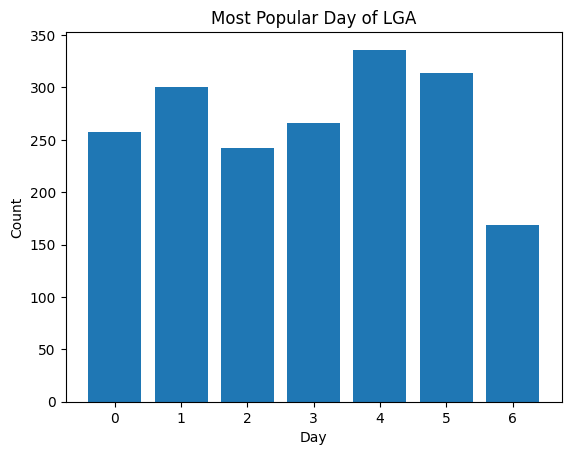

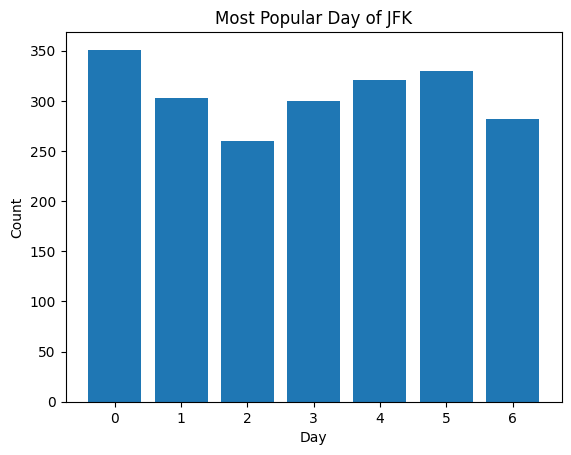

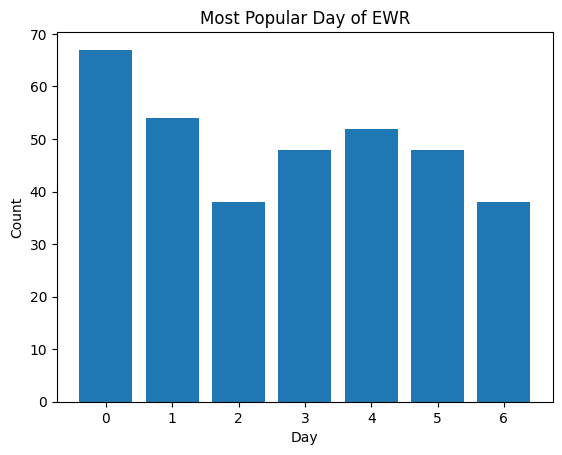

In [74]:
plot_dropoffs_for_lga_airport()
plot_dropoffs_for_jfk_airport()
plot_dropoffs_for_ewr_airport()

### Visualization 5
Create a scatter plot that compares tip amount versus distance.

In [19]:
def plot_tip_amount_distance():
    plt.subplots(figsize=(20, 10))
    query="""SELECT tip_amount as Tip_Amt, distance as Distance FROM taxi_trips"""
    # get data of distance & tip amount from taxi trips
    df=get_data_for_visual_n(query)
    # set distance as x-axis & tip_amount as y-axis
    x=df["Distance"]
    y=df["Tip_Amt"]
    # label x & y axes
    plt.xlabel("Distance")
    plt.ylabel("Tip_Amt")
    # set title
    plt.title("Tip Amount versus Distance")
    # make scatter plot
    plt.scatter(x,y)
    plt.show()

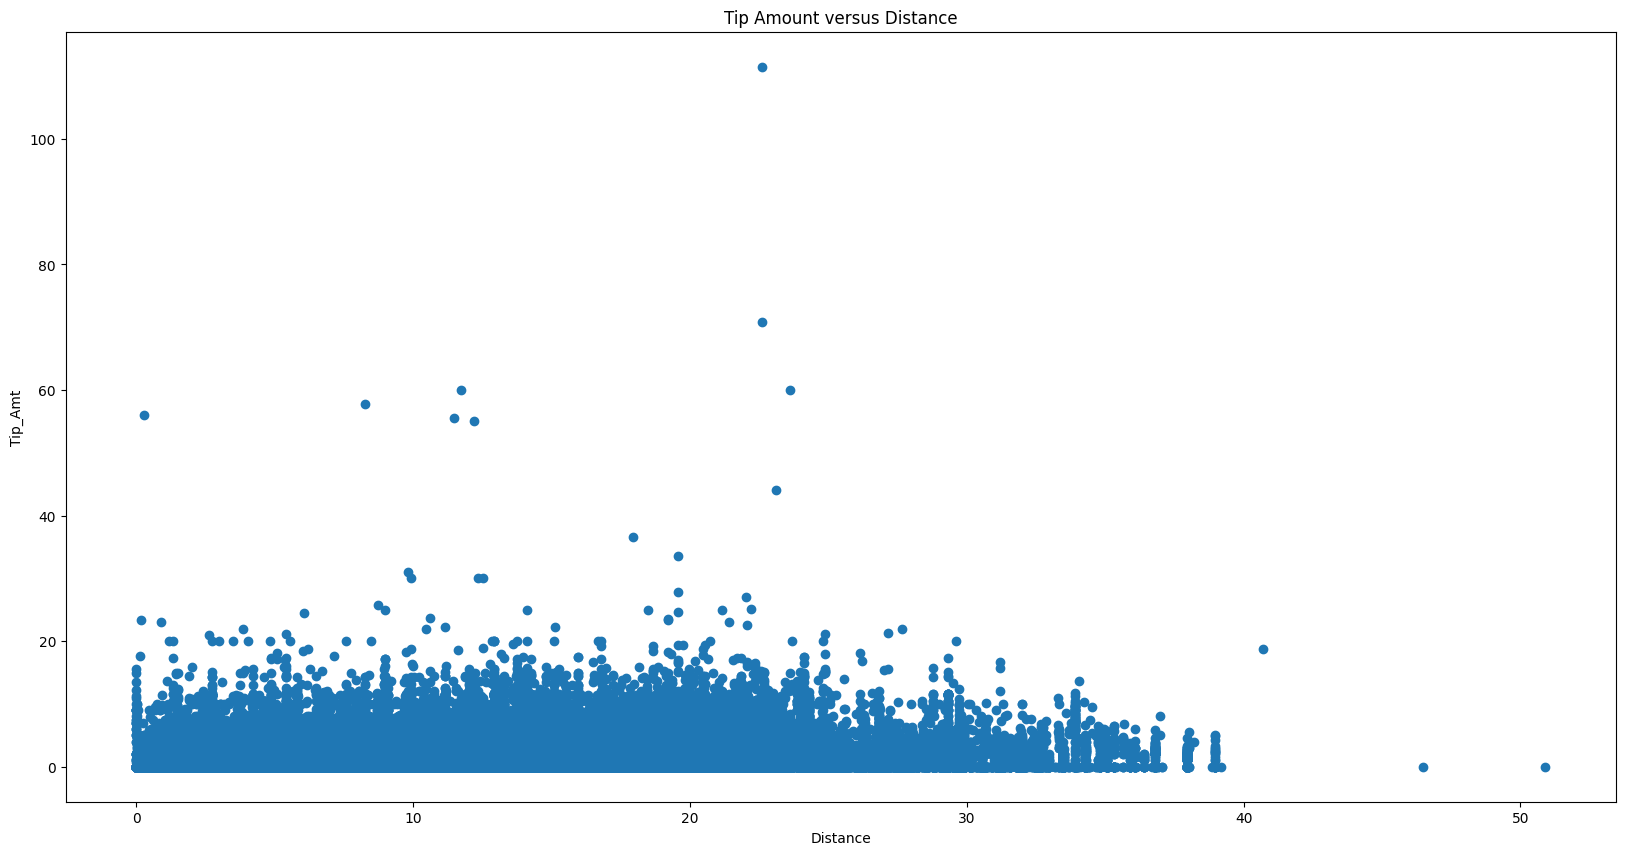

In [20]:
plot_tip_amount_distance()

In [25]:
def plot_tip_amount_precipitation():
    plt.subplots(figsize=(30, 10))
    
    # get data of tip amount from taxi trips and get data of precipitation from weather
    taxi_df=get_data_for_visual_n("""SELECT strftime ('%Y-%m-%d %H',pickup_datetime) AS Hr, tip_amount as Tip_Amt FROM taxi_trips""")
    weather_df=get_data_for_visual_n("""SELECT strftime ('%Y-%m-%d %H',DATE) AS Hr, HourlyPrecipitation as precipitation FROM hourly_weather""")
    df=pd.merge(taxi_df, weather_df, on="Hr")
    # set precipitation as x-axis & tip_amount as y-axis
    x=df["precipitation"]
    y=df["Tip_Amt"]
    # label x & y axes
    plt.xlabel("precipitation")
    plt.ylabel("Tip_Amt")
    # set title
    plt.title("Tip Amount versus precipitation amount")
    # make scatter plot
    plt.xticks(rotation=45)
    plt.scatter(x,y)
    plt.show()

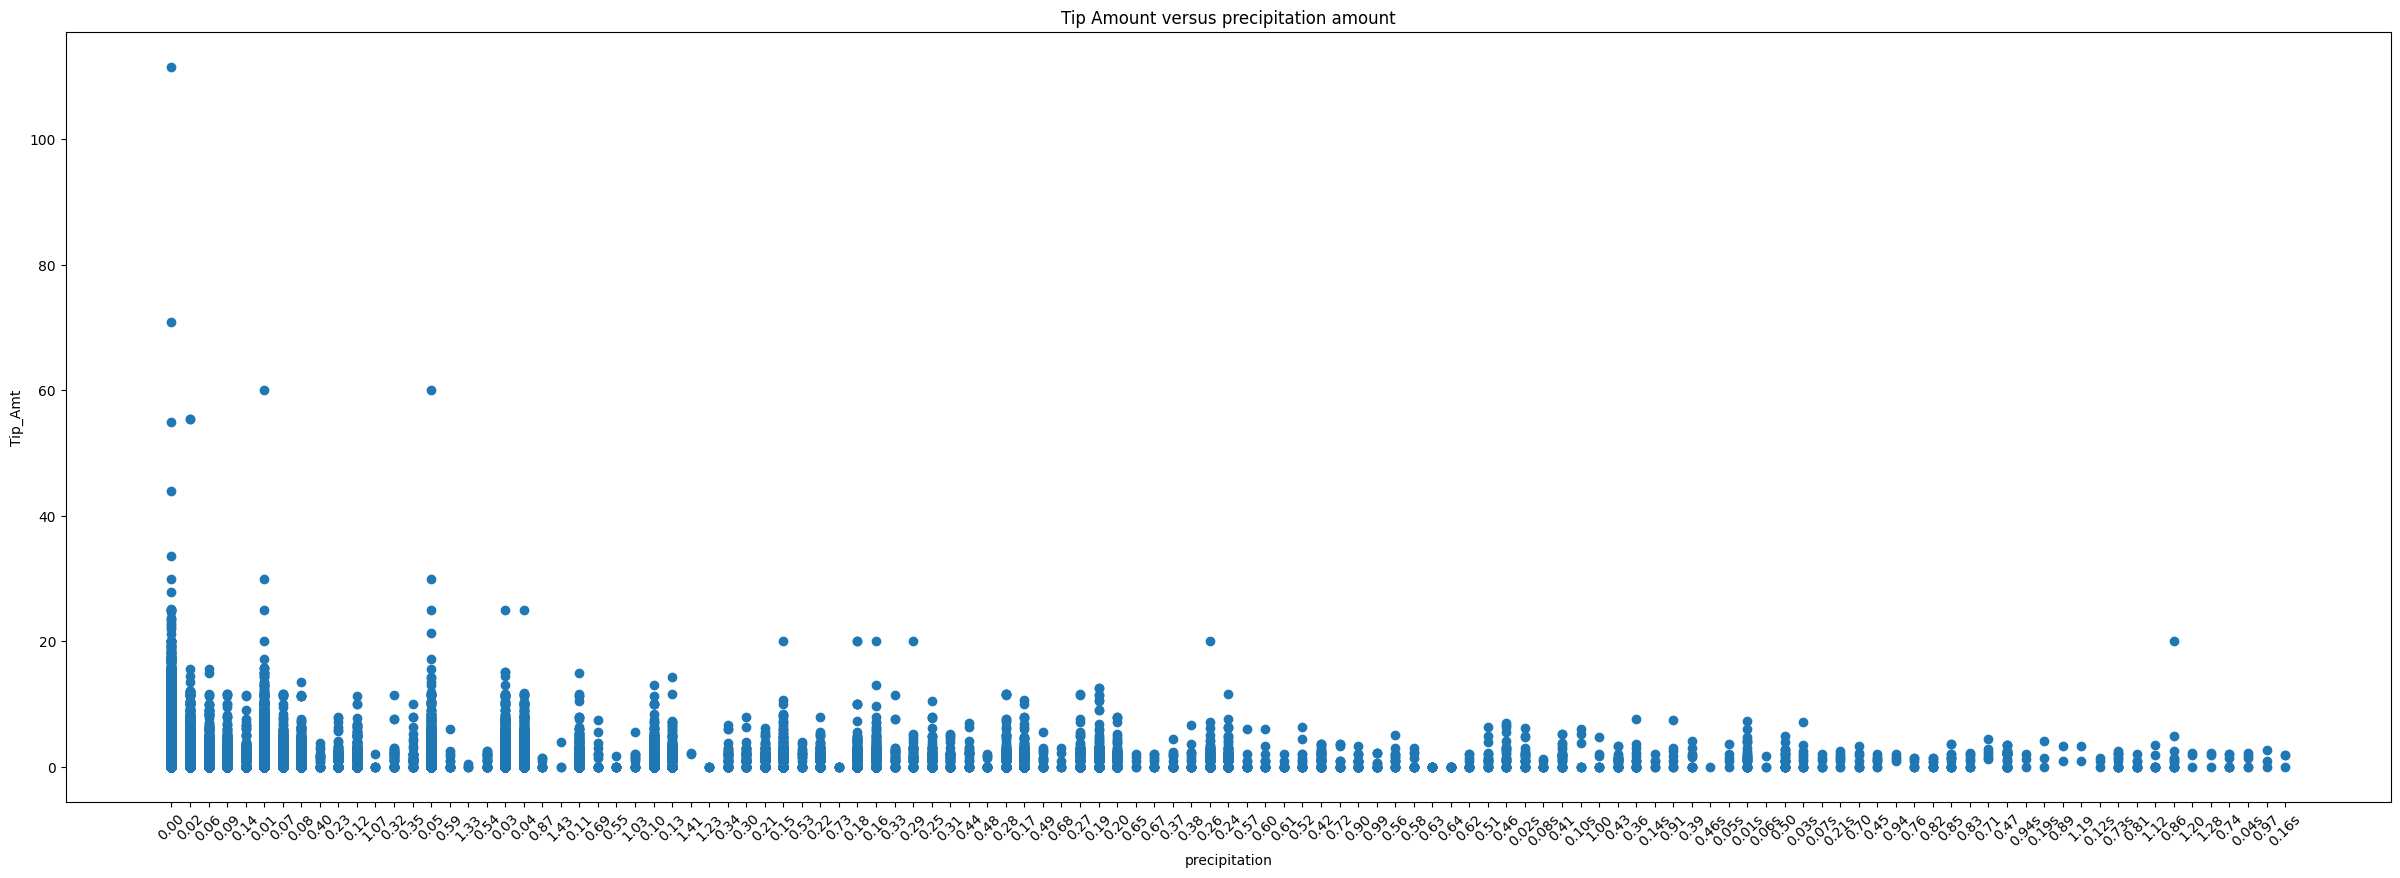

In [26]:
plot_tip_amount_precipitation()